<a href="https://colab.research.google.com/github/Confirmation-Bias-Analyser/Main-Program/blob/temp/Main_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install sentence_transformers
!pip install vaderSentiment
!pip install anytree
!pip install dash
!pip install jupyter-dash
!pip install pyyaml==5.4.1
!pip install pyvis

In [2]:
%%capture

from transformers import BertTokenizer, TFBertForSequenceClassification, InputExample, InputFeatures
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import files
from anytree import Node, RenderTree, search
import random
import re
import urllib
from urllib.parse import urlparse

# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
import json
from sklearn.cluster import KMeans

import sys
mainDirectory = "/content/drive/MyDrive/Final Year Project/Key Notebooks/Main Program/"
sys.path.append(mainDirectory)
from functions import *

from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

from jupyter_dash import JupyterDash
from dash import Dash, html, Input, Output, dash_table, dcc
from dash.dependencies import Input, Output
from IPython.core.display import display, HTML
import plotly.express as px

In [3]:
with open(mainDirectory + 'twitter_bearer_token.txt', 'r', encoding="utf8") as f:
    token = f.read()

header = create_Twitter_headers(token)

# Data Collection

In [4]:
with open(mainDirectory + 'database_uri.txt', 'r', encoding="utf8") as f:
    uri = f.read()

socialMedia = ['Reddit', 'Twitter', 'PHEME Dataset']

for i in range(len(socialMedia)):
    print(i, socialMedia[i])

socialMediaOption = 1

print(f'\nChosen {socialMedia[socialMediaOption]}\n')

if socialMedia[socialMediaOption] == 'Reddit':
    parent = 'rmqevj'
    query = '''
        select * from reddit_posts_for_analysis where head_id = '%s'
    '''% parent
    df = getData(query, uri)
    
elif socialMedia[socialMediaOption] == 'Twitter':
    conversationID = '1522931750451617793'
    # conversationID = '1507922082683793408'

    query = '''
        select * from comments_for_analysis where conversation_id = '%s'
    '''% conversationID
    
    df = getData(query, uri)

    parent = df['head_id'][0]

    print('About the tweet:')
    print(getSingleTweetInfo(conversationID, header)['data'][0]['text'])

    print('Number of comments:', len(df))

elif socialMedia[socialMediaOption] == 'PHEME Dataset':
    parent = '553553331671408641'
    query = '''
        select * from pheme_dataset_for_analysis where head_id = '%s'
    '''% parent
    df = getData(query, uri)

df['url'] = df['comment'].apply(lambda x: getLinks(x))
df['link_title'] = df['url'].apply(lambda x: getURLfromList(x))
df.head()

0 Reddit
1 Twitter
2 PHEME Dataset

Chosen Twitter

About the tweet:
Over 100 people protest against Covid-19 vaccines with Healing the Divide founder Iris Koh https://t.co/QrY9DhO9sF https://t.co/x1C47MOzUm
Number of comments: 41


,id,timestamp,reply_to,comment,social_media,head_id,conversation_id,user_id,url,link_title
0,10038,2022-05-07T13:40:35.000Z,1619325942,@MothershipSG Why were they not arrested for i...,Twitter,1619325942,1522931750451617793,1474416398,,
1,10000,2022-05-08T15:09:14.000Z,10038,@zacroix @MothershipSG Is about time for peopl...,Twitter,1619325942,1522931750451617793,1520451553165193216,,
2,10001,2022-05-08T11:36:53.000Z,1619325942,@MothershipSG Lanjiao ah! Healing the divide b...,Twitter,1619325942,1522931750451617793,1348988297205305345,,
3,10002,2022-05-08T11:30:17.000Z,1619325942,@MothershipSG She's a clown,Twitter,1619325942,1522931750451617793,770445136371167232,,
4,10003,2022-05-08T11:21:23.000Z,1619325942,@MothershipSG For every protest in any country...,Twitter,1619325942,1522931750451617793,1516288928047071233,,


In [5]:
root = Node(parent)

input_list = [] 

item_count = df['reply_to'].value_counts().to_dict()

for i in range(len(df['id'].tolist())):
    try:
      if df['id'].loc[i] != df['reply_to'].loc[i]:
          input_list.append((df['id'].loc[i], df['reply_to'].loc[i]))

    except:
      continue

In [6]:
output_dict = make_map(input_list)
createTweetsTree(output_dict[parent], root)

# Sentiment Analysis

In [7]:
pred_sentences = cleanComments(df['comment'])

In [8]:
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/subjectivity_tokenizer/")
model = TFBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_subjectivity_model/")

In [9]:
def predictFromModel(model, tokeniser, data):
    tf_batch = tokeniser(data, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

    return tf_predictions[:,1]

In [10]:
textblob_polarity = []
textblob_subjectivity = []
vader_results = []
vaderCompoundScores = []
model_subjectivity_result = predictFromModel(model, tokenizer, pred_sentences)

for i in pred_sentences:
  result = getSentimentalResults(i)
  textblob_polarity.append(result['textblob_polarity'])
  textblob_subjectivity.append(result['textblob_subjectivity'])
  vader_results.append(result['vader_results'])
  vaderCompoundScores.append(result['vader_compound_scores'])

In [11]:
df['number_of_links'] = df['link_title'].apply(lambda x: len(x))

# Polarity
df['textblob_polarity'] = textblob_polarity
df['vader_compound_score'] = vaderCompoundScores
df['vader_polarity'] = df['vader_compound_score'].apply(lambda x: polarityDetermination(x))

overall_polarity = []
overall_polarity_scores = {}

for i in range(len(textblob_polarity)):
  overall_polarity.append(definePolarity(textblob_polarity[i], vaderCompoundScores[i]))
  overall_polarity_scores[df['id'][i]] = [textblob_polarity[i], vaderCompoundScores[i]]

df['overall_polarity'] = overall_polarity

# Subjectivity
df['model_subjectivity'] = model_subjectivity_result
df['textblob_subjectivity'] = textblob_subjectivity

overall_subjectivity = []
overall_subjectivity_scores = {}

for i in range(len(model_subjectivity_result)):
  overall_subjectivity.append(defineSubjectivity(model_subjectivity_result[i], textblob_subjectivity[i]))
  overall_subjectivity_scores[df['id'][i]] = [float(model_subjectivity_result[i]), textblob_subjectivity[i]]

df['overall_subjectivity'] = overall_subjectivity

df['vader_sentiment'] = vader_results
df['topic_cluster'] = getClusters(pred_sentences, embedder)

df['potential_bias'] = flagPotentialBias(df)

df.to_csv('sentiment_result.csv', index=False)
df.head()

,id,timestamp,reply_to,comment,social_media,head_id,conversation_id,user_id,url,link_title,...,textblob_polarity,vader_compound_score,vader_polarity,overall_polarity,model_subjectivity,textblob_subjectivity,overall_subjectivity,vader_sentiment,topic_cluster,potential_bias
0,10038,2022-05-07T13:40:35.000Z,1619325942,@MothershipSG Why were they not arrested for i...,Twitter,1619325942,1522931750451617793,1474416398,,,...,-0.500,0.6681,POS,UNKNOWN,0.000876,0.50,OBJECTIVE,"{'neg': 0.0, 'neu': 0.523, 'pos': 0.477}",0,0
1,10000,2022-05-08T15:09:14.000Z,10038,@zacroix @MothershipSG Is about time for peopl...,Twitter,1619325942,1522931750451617793,1520451553165193216,,,...,0.125,-0.4364,NEG,UNKNOWN,0.003720,0.45,OBJECTIVE,"{'neg': 0.121, 'neu': 0.879, 'pos': 0.0}",0,0
2,10001,2022-05-08T11:36:53.000Z,1619325942,@MothershipSG Lanjiao ah! Healing the divide b...,Twitter,1619325942,1522931750451617793,1348988297205305345,,,...,0.500,0.0000,NEU,UNKNOWN,0.003858,0.50,OBJECTIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",0,0
3,10002,2022-05-08T11:30:17.000Z,1619325942,@MothershipSG She's a clown,Twitter,1619325942,1522931750451617793,770445136371167232,,,...,0.000,0.0000,NEU,NEU,0.003196,0.00,OBJECTIVE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0}",0,0
4,10003,2022-05-08T11:21:23.000Z,1619325942,@MothershipSG For every protest in any country...,Twitter,1619325942,1522931750451617793,1516288928047071233,,,...,0.000,-0.2500,NEU,NEU,0.003846,0.00,OBJECTIVE,"{'neg': 0.143, 'neu': 0.857, 'pos': 0.0}",0,0


In [12]:
df[['id','comment','textblob_polarity','vader_compound_score','vader_polarity','model_subjectivity','textblob_subjectivity','topic_cluster','potential_bias']].head()

,id,comment,textblob_polarity,vader_compound_score,vader_polarity,model_subjectivity,textblob_subjectivity,topic_cluster,potential_bias
0,10038,@MothershipSG Why were they not arrested for i...,-0.500,0.6681,POS,0.000876,0.50,0,0
1,10000,@zacroix @MothershipSG Is about time for peopl...,0.125,-0.4364,NEG,0.003720,0.45,0,0
2,10001,@MothershipSG Lanjiao ah! Healing the divide b...,0.500,0.0000,NEU,0.003858,0.50,0,0
3,10002,@MothershipSG She's a clown,0.000,0.0000,NEU,0.003196,0.00,0,0
4,10003,@MothershipSG For every protest in any country...,0.000,-0.2500,NEU,0.003846,0.00,0,0


# Confirmation Bias Analysis

In [13]:
head_thread = parent #input('Enter a comment to look at the replies. ')
conversationDF, conversationTree = traceConversation(df, root, head_thread, False)

In [14]:
print("About the tweet")

print("Existence of links:")
checkLink = False

for i in df['link_title']:
    if isinstance(i, list):
        print(i)
        checkLink = False

if checkLink:
    print("No links")
else:
  print("\nThe exact link in the comments:")
  for i in df['url']:
      if len(i) > 0:
          print(i)

About the tweet
Existence of links:
['twitter.com']
['twitter.com']
['t.me']
['twitter.com']
['amp.theguardian.com']

The exact link in the comments:
https://twitter.com/DoctorStone96/status/1523003027195850752/photo/1;
https://twitter.com/xandermateusz/status/1522983062346166272/photo/1;
https://t.me/childcovidvaccineinjuriesuk;
https://twitter.com/Ach1llesHeel/status/1522950563167555590/photo/1;
https://amp.theguardian.com/environment/2022/apr/06/microplastics-found-deep-in-lungs-of-living-people-for-first-time;


In [15]:
print()

for i in df['url']:
    if isinstance(i, list):
        print(i)

In [16]:
print("Conversation Tree")
printGraph(root)

Conversation Tree
1619325942
├── 10038
│   ├── 10000
│   └── 10021
├── 10001
├── 10002
├── 10003
├── 10004
├── 10008
├── 10009
├── 10010
├── 10011
├── 10017
├── 10019
├── 10020
├── 10022
├── 10023
├── 10024
├── 10025
├── 10026
├── 10028
├── 10030
├── 10031
├── 10033
├── 10035
├── 10036
├── 10037
├── 10039
│   └── 10034
└── 10040
    └── 10016


In [17]:
print("Confirmation Bias Score for Entire Conversation:", calculateBias(conversationDF))
print("Number of potentially bias comments:", len(conversationDF[conversationDF['potential_bias'] == 1]))

Confirmation Bias Score for Entire Conversation: 0.9000000000000001
Number of potentially bias comments: 11


In [18]:
scoreLists = ['number_of_links', 'vader_compound_score', 'textblob_polarity', 'textblob_subjectivity', 'model_subjectivity', 'overall_subjectivity', 'overall_polarity', 'topic_cluster', 'potential_bias']
df_for_visualisation = conversationDF[['id','timestamp','reply_to','comment'] + scoreLists]

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H4('Conversation'),
    html.P(id='table_out'),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in ['id'] + scoreLists],
        data=df_for_visualisation.to_dict('records'),
        style_cell={
            'textAlign': 'center',
        },
        style_as_list_view=True,
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender"),
    ), 
])

@app.callback(
    Output('table_out', 'children'), 
    Input('table', 'active_cell'))

def update_graphs(active_cell):
    if active_cell:
        identifier = df_for_visualisation.iloc[active_cell['row']]['id']
        comment = df_for_visualisation.iloc[active_cell['row']]['comment']

        return f"Selected ID: {identifier}, Comment by user: \"{comment}\"" #, {score}"
    return "Click the table"

app.run_server(mode='inline')#debug=True

<IPython.core.display.Javascript object>

In [19]:
def obtainTweetsAndLikes(userID, header):
    selectedUserTweets = getTweetsByUserID(userID, header, 100)
    userLikedTweets = getTweetsLikedByUser(userID, header, 100)
    allTweets = combineTweets([selectedUserTweets, userLikedTweets])

    return allTweets

def combineTweets(listOfTweets):
    allTweets_ = []

    for i in listOfTweets:
        for j in i['data']:
            allTweets_.append(j['text'])

    return allTweets_

def checkForRepliesToNews(textList):
    result = []
    for i in textList:
        reply = re.findall("(@[A-Za-z0-9]+)", i)

        if any(x in ['@MothershipSG', '@straits_times', '@ChannelNewsAsia', '@YahooSG'] for x in reply):
            result.append(i)

    return result

def calculateUserBias(tweetsData, embedder, defaultClusterSize = 3):
    user_tweets = []
    textblob_polarity_res = []
    textblob_subjectivity_res = [] 
    vader_compound_scores = []
    model_subjectivity_score = []
    clean_text = []

    for i in tweetsData:
        # repliedAccounts = re.findall("(@[A-Za-z0-9]+)", i)

        # if any(x in ['@MothershipSG', '@straits_times', '@ChannelNewsAsia'] for x in repliedAccounts):
        user_tweets.append(i)
        reply = cleanComments([i])
        clean_text.append(reply[0])
        sentimentalResults = getSentimentalResults(reply[0])

        textblob_polarity_res.append(sentimentalResults['textblob_polarity'])
        textblob_subjectivity_res.append(sentimentalResults['textblob_subjectivity'])
        vader_compound_scores.append(sentimentalResults['vader_compound_scores'])
        model_subjectivity_score.append(float(predictFromModel(model, tokenizer, reply)))

    overall_subjectivity = []
    for i in range(len(model_subjectivity_score)):
        overall_subjectivity.append(defineSubjectivity(model_subjectivity_score[i], textblob_subjectivity_res[i]))

    overall_polarity = []
    for i in range(len(textblob_polarity_res)):
        overall_polarity.append(definePolarity(textblob_polarity_res[i], vader_compound_scores[i]))

    cluster = getClusters(clean_text, embedder, defaultClusterSize)

    df = pd.DataFrame(list(zip(user_tweets, textblob_polarity_res, textblob_subjectivity_res, vader_compound_scores, model_subjectivity_score, overall_subjectivity, overall_polarity, cluster)),
                      columns =['tweet', 'textblob_polarity', 'textblob_subjectivity', 'vader_compound_score', 'model_subjectivity', 'overall_subjectivity', 'overall_polarity', 'topic_cluster'])
    
    return df

In [20]:
for index, row in conversationDF[conversationDF['potential_bias'] == 1].iterrows():
    print(row['id'], row['comment'])

10008 @MothershipSG What is there to protest now no need to trace together u can go anywhere u want too free these people
10011 @MothershipSG Not surprising.
It's this category of people who would vote for Donald Trump and Bombong Marcos.
They would probably declare that Russia's invasion of Ukraine is justified.
They're breathing the wrong air in the wrong country.
10016 @K31thc0m @MothershipSG Oh yeah, I don't need to safe entry to most of not all places... The ship has sailed ATM. Which is probably why the permit was granted in the first place. Ok la now I give you talk.
10017 @MothershipSG Well, lets see what latest research says about vaccine vs Omicron: 💁‍♂️ https://t.co/PY8EbJQS6Y
10019 @MothershipSG What a joke. 100 plus people out of 5.68 million people in Singapore. As if that’s going to make a difference. Blind leading the blind.
10020 @MothershipSG nobody's stopping you https://t.co/Nj2znrlW7w
10022 @MothershipSG "I am healthy I have an immune system" is possibly one of the

### Get the Replies and Retweets of Potentially Bias Users

In [21]:
# suspectedBiasUsers = ['CardanoAdonis', 'PLafala', 'Erwin_Dawson', 'Coldcappuccino9', '_5andman_', 'Actarus_dEuphor', 'ResenT___', 'mkggoh', 'slowpokemax']

# for i in suspectedBiasUsers:
#     userID = getTwitterUserInfo(i, header)['data'][0]['id']
#     allUserTweets = combineTweets([getTweetsByUserID(userID, header, 100)])

#     print('***********', i, '***********')

#     for j in checkForRepliesToNews(allUserTweets):
#         print(j)

#     print()    

In [22]:
len(conversationDF[conversationDF['potential_bias'] == 1]['user_id'].unique())

11

In [23]:
for i in conversationDF[conversationDF['potential_bias'] == 1]['user_id']:
    allUserTweets = combineTweets([getTweetsByUserID(i, header, 100)])

    print('***********', i, '***********')

    for j in checkForRepliesToNews(allUserTweets):
        print(j)

    print()    

*********** 1531214377 ***********
@MothershipSG Aiya myy husband has never gotten anything for me all this years it’s not that he dun love me it’s juz his character…… what to do I chose him I live with it look on the bright side
@MothershipSG What is there to protest now no need to trace together u can go anywhere u want too free these people
@MothershipSG so that means u ruling out of being friendly with Singapore cos u and China no good?
@MothershipSG From the photo  his income from FP is much more than the other two so FP has got the big pie of the market?
@MothershipSG Singaporeans like to follow trend I really many years ago one person committed suicide on mrt track den a few others try to play the same stunt
@MothershipSG From her tone and the way she speaks she is not a local ! From our neighboring countries! Still so yayapapaya here ? Married here so what? Big deal?
@YahooSG Where did he get his confidence from?
@ChannelNewsAsia How is PSLE gonna be like and their grading?
@Mo

### Get the Liked Tweets by Potentially Bias Users

In [24]:
# for i in suspectedBiasUsers:
#     userID = getTwitterUserInfo(i, header)['data'][0]['id']
#     allUserTweets = combineTweets([getTweetsLikedByUser(userID, header, 100)])

#     print('***********', i, '***********')

#     for j in checkForRepliesToNews(allUserTweets):
#         print(j)

#     print()    

In [25]:
for i in conversationDF[conversationDF['potential_bias'] == 1]['user_id']:
    allUserTweets = combineTweets([getTweetsLikedByUser(i, header, 100)])

    print('***********', i, '***********')

    for j in checkForRepliesToNews(allUserTweets):
        print(j)

    print()    

*********** 1531214377 ***********
@zheng_corinne @MothershipSG If I suspect that she is where she is from, she wouldn't articulate her distaste in such a manner in her own backyard. Perhaps she would remain muted, hence the hyper aggressive display. Then again, that's no excuse for such ugly behaviour. Shame on her!
@MothershipSG See la..govt want us to integrate with foreigners leh...how? only Integrated Bus Interchange maybe la.
泼妇。

*********** 804973086567055360 ***********
For 3 months I've been travelling for a travelogue on SE Asia and its hidden gems. Many stunning places, amazing people and fascinating stories. ASEAN has its problems, but also beauty. Get excited for @ChannelNewsAsia's 5-part doco Tapestry: The Heart of ASEAN 📺 Premiere: 27Feb https://t.co/f6VDbSY7HG
My "studio" for the weekend covering #ShangriLaDialogue @ShangriLaSG #SLD17 join me @ChannelNewsAsia https://t.co/EuLKjlCs2R

*********** 83822931 ***********

*********** 3246610436 ***********

*********** 1365

# Visualise the Graph

In [26]:
# G = createNetworkGraph(conversationTree, head_thread)
polarity_map, subjectivity_map, pb_map = getColourNodes(conversationDF)

In [27]:
net = createInterativeNetworkGraph(conversationTree, head_thread, polarity_map, overall_polarity_scores)
net.show('edges.html')
print('Polarity Scores')
print('Legend: Green - Positive polarity,', 'Pink - Negative polarity,', 'Yellow - Neutral or Unknown')

display(HTML('edges.html'))

Polarity Scores
Legend: Green - Positive polarity, Pink - Negative polarity, Yellow - Neutral or Unknown


In [28]:
net = createInterativeNetworkGraph(conversationTree, head_thread, subjectivity_map, overall_subjectivity_scores)
net.show('edges.html')
print('Subjectivity Scores')
print('Legend: Light Grey - Subjective comment,', 'Light Blue - Objective comment,', 'Orange - Unknown')

display(HTML('edges.html'))

Subjectivity Scores
Legend: Light Grey - Subjective comment, Light Blue - Objective comment, Orange - Unknown


In [29]:
net = createInterativeNetworkGraph(conversationTree, head_thread, pb_map, [])
net.show('edges.html')
print('Legend: Red - Potential Bias,', 'Black - Potential Unbias')

display(HTML('edges.html'))

Legend: Red - Potential Bias, Black - Potential Unbias


# Other Additional Visualisation

vader_polarity
NEG     9
NEU    16
POS     5
dtype: int64


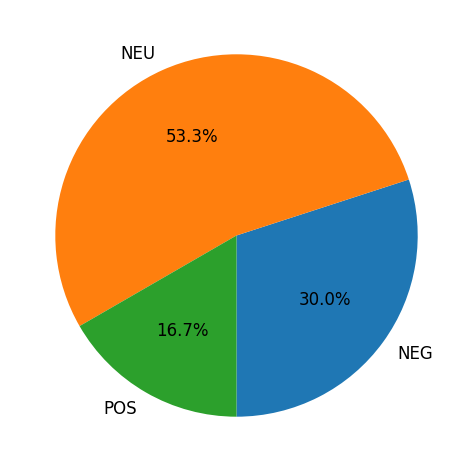

In [30]:
# Let's count the number of tweets by sentiments
sentiment_counts = conversationDF.groupby(['vader_polarity']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

topic_cluster
0    18
1    12
dtype: int64


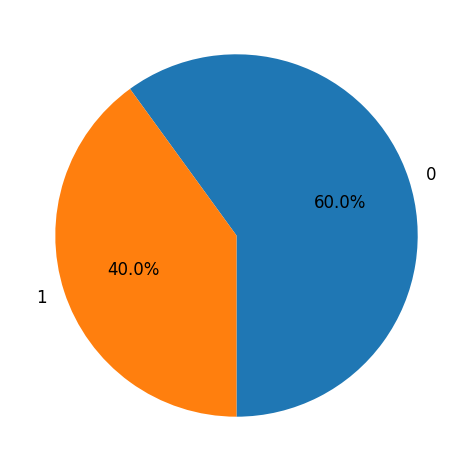

In [31]:
topic_cluster_counts = conversationDF.groupby(['topic_cluster']).size()
print(topic_cluster_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
topic_cluster_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

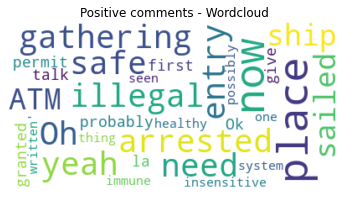

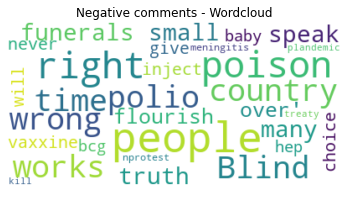

In [32]:
# Wordcloud with positive tweets
positive_tweets = []
for i in conversationDF[conversationDF["vader_polarity"] == 'POS']['comment'].tolist():
    positive_tweets.append(re.sub("(@[A-Za-z0-9]+)", "", i))

if len(positive_tweets) != 0:
    stop_words = ["https", "co", "RT"] + list(STOPWORDS)
    positive_wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
    plt.figure()
    plt.title("Positive comments - Wordcloud")
    plt.imshow(positive_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Wordcloud with negative tweets
negative_tweets = []
for i in conversationDF[conversationDF["vader_polarity"] == 'NEG']['comment'].tolist():
    negative_tweets.append(re.sub("(@[A-Za-z0-9]+)", "", i))

if len(negative_tweets) != 0:
    stop_words = ["https", "co", "RT"] + list(STOPWORDS)
    negative_wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
    plt.figure()
    plt.title("Negative comments - Wordcloud")
    plt.imshow(negative_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()